In [185]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt

In [22]:
# load data
df = pd.read_csv('Processed_data/claims.csv',index_col=0)
df.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30


In [23]:
# drop cases without claim_id and enrollee_id
df.dropna(subset = ['claim_id','enrollee_id'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323140 entries, 0 to 323148
Data columns (total 13 columns):
claim_id           323140 non-null float64
enrollee_id        323140 non-null float64
provider_id        323140 non-null float64
provider_status    323140 non-null float64
hmo_id             323140 non-null float64
care_id            323140 non-null float64
qty                323140 non-null float64
amount             323140 non-null float64
approved_qty       323140 non-null float64
approved_amount    323140 non-null float64
hmo_approved       323140 non-null float64
created_at         323140 non-null object
vetted_at          282380 non-null object
dtypes: float64(11), object(2)
memory usage: 34.5+ MB


In [36]:
# check value range
for col in df.columns[:-1]:
    print(col)
    print(df[col].min(),df[col].max())

claim_id
10.0 65243.0
enrollee_id
1.0 153580.0
provider_id
1.0 436.0
provider_status
0.0 1.0
hmo_id
1.0 5.0
care_id
2.0 91038.0
qty
-60.0 15000.0
amount
-48000.0 2850000.0
approved_qty
-60.0 12000.0
approved_amount
-48000.0 2850000.0
hmo_approved
-1.0 1.0
created_at
2018-03-12 14:53:46 2020-01-16 17:30:50


In [38]:
# drop negative cases
clean_df = df.drop(df.loc[df['qty'] < 0].index,axis=0)

In [40]:
# check again
for col in clean_df.columns[:-1]:
    print(col)
    print(clean_df[col].min(),clean_df[col].max())

claim_id
10.0 65243.0
enrollee_id
1.0 153580.0
provider_id
1.0 436.0
provider_status
0.0 1.0
hmo_id
1.0 5.0
care_id
2.0 91038.0
qty
0.0 15000.0
amount
0.0 2850000.0
approved_qty
0.0 12000.0
approved_amount
-1.0 2850000.0
hmo_approved
-1.0 1.0
created_at
2018-03-12 14:53:46 2020-01-16 17:30:50


In [253]:
# check untouched cases, could used as testing cases
testing_cases = clean_df.loc[clean_df['hmo_approved'] == 0]

In [254]:
# drop unprocessed cases
clean_df = clean_df.loc[clean_df['hmo_approved'] != 0]
clean_df.shape

(282371, 13)

In [257]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282371 entries, 0 to 319563
Data columns (total 13 columns):
claim_id           282371 non-null float64
enrollee_id        282371 non-null float64
provider_id        282371 non-null float64
provider_status    282371 non-null float64
hmo_id             282371 non-null float64
care_id            282371 non-null float64
qty                282371 non-null float64
amount             282371 non-null float64
approved_qty       282371 non-null float64
approved_amount    282371 non-null float64
hmo_approved       282371 non-null float64
created_at         282371 non-null object
vetted_at          282371 non-null object
dtypes: float64(11), object(2)
memory usage: 30.2+ MB


In [266]:
# choose features for X
X = clean_df[['enrollee_id','provider_id','provider_status','hmo_id','care_id','qty','amount']]

# the approved cases are True, and would be classified as 0, we consider problematic cases to be positive
y = (clean_df['hmo_approved'] == 1) & (clean_df['approved_amount'] == clean_df['amount'])
y = y.map({True:0,False:1}) 

In [267]:
X.shape,y.shape

((282371, 7), (282371,))

In [268]:
# train_test spilt
Xtrain,Xtest,ytrain,ytest = train_test_split(X.values,y.values,test_size = 0.2,random_state=42)


In [270]:
# check data unbalance for training data
(ytrain == 0).sum(),(ytrain == 1).sum(),(ytrain == 0).sum()/(ytrain == 1).sum()

(214788, 11108, 19.3363341735686)

In [271]:
# check data unbalance for testing data
(ytest == 0).sum(),(ytest == 1).sum(),(ytest == 0).sum()/(ytest == 1).sum()

(53663, 2812, 19.08357041251778)

In [261]:
def evaluation(ytest,Xtest,cls):
    """
    model evaluation function:
    
    """
    
    ypred = cls.predict(Xtest)
    C = confusion_matrix(ytest,ypred)
    TN = C[0][0] # true negatives
    FN = C[1][0] # false negatives
    TP = C[1][1] # true positives 
    FP = C[0][1] # false positives

    print('f1_socre: {:1f}'.format(f1_score(ytest,ypred)))
    print('precision: {:1f}'.format((TP)/(TP+FP)))
    print('recall/sensitivity(true positive rate): {:1f}'.format((TP)/(TP+FN)))
    print('spcificity(true negative rate): {:1f}'.format(TN/(TN+FP)))
    print('false positive rate (FPR): {:1f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    print('ROC_AUC_score: {:1f}'.format(roc_auc_score(ytest,ypred))) # area under curve
    

In [227]:
def cv(Xtrain,ytrain,model):
    
    """
    4-fold cross validation
    """
    
    models = []
    kf = KFold(n_splits=4)
    print(model)
    n = 0
    for train_index, test_index in kf.split(Xtrain):
        print('cross_validate_run: {}'.format(n))
        Xtr, Xte = Xtrain[train_index], Xtrain[test_index]
        ytr, yte = ytrain[train_index], ytrain[test_index]
        cls = model.fit(Xtr, ytr) 
        models.append(cls)
        evaluation(yte,Xte,cls)
        n += 1
    return models

# naive bayes

In [272]:
# choose complement naive bayes to handle imbalanced data
model1 = ComplementNB()
models = cv(Xtrain,ytrain,model1)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.124268
precision: 0.074684
recall/sensitivity(true positive rate): 0.369745
spcificity(true negative rate): 0.762549
false positive rate (FPR): 0.237451
ROC_AUC_score: 0.566147
cross_validate_run: 1
f1_socre: 0.122076
precision: 0.074156
recall/sensitivity(true positive rate): 0.345055
spcificity(true negative rate): 0.781166
false positive rate (FPR): 0.218834
ROC_AUC_score: 0.563111
cross_validate_run: 2
f1_socre: 0.126061
precision: 0.077524
recall/sensitivity(true positive rate): 0.337147
spcificity(true negative rate): 0.790953
false positive rate (FPR): 0.209047
ROC_AUC_score: 0.564050
cross_validate_run: 3
f1_socre: 0.123961
precision: 0.076003
recall/sensitivity(true positive rate): 0.335954
spcificity(true negative rate): 0.787093
false positive rate (FPR): 0.212907
ROC_AUC_score: 0.561524


In [273]:
# evaluate test data
evaluation(ytest,Xtest,models[-1])

f1_socre: 0.122000
precision: 0.075074
recall/sensitivity(true positive rate): 0.325391
spcificity(true negative rate): 0.789930
false positive rate (FPR): 0.210070
ROC_AUC_score: 0.557660


In [264]:
# categorical naive bayes to hanle categorical data
model2 = CategoricalNB()
cv(Xtrain,ytrain,model2)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)
cross_validate_run: 0


IndexError: index 88485 is out of bounds for axis 1 with size 87559

# Xgboost

In [274]:
# xgboost: use scale_pos_weight to handle imbalanced data
model3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
              silent=None, subsample=1, verbosity=1)
models_xgb = cv(Xtrain,ytrain,model3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.247212
precision: 0.149885
recall/sensitivity(true positive rate): 0.704995
spcificity(true negative rate): 0.792740
false positive rate (FPR): 0.207260
ROC_AUC_score: 0.748867
cross_validate_run: 1
f1_socre: 0.249840
precision: 0.151430
recall/sensitivity(true positive rate): 0.713553
spcificity(true negative rate): 0.796889
false positive rate (FPR): 0.203111
ROC_AUC_score: 0.755221
cross_validate_run: 2
f1_socre: 0.246877
precision: 0.150213
recall/sensitivity(true positive rate): 0.6925

In [275]:
# evaluate testing data
evaluation(ytest,Xtest,models_xgb[-2])

f1_socre: 0.254277
precision: 0.155205
recall/sensitivity(true positive rate): 0.703058
spcificity(true negative rate): 0.799471
false positive rate (FPR): 0.200529
ROC_AUC_score: 0.751265


In [169]:
#pickle.dump(model5,open("Models/xgb1.dat", "wb"))


# use upsampling training sample to handle data imbalance

In [276]:
# upsampling of positive data input
Xy = X.copy()
Xy['y'] = y

class0 = Xy.loc[Xy.y == 0]
class1 = Xy.loc[Xy.y == 1]
print(class0.shape,class1.shape)

(268451, 8) (13920, 8)


In [277]:
class1 = class1.sample(n=class0.shape[0],replace=True,random_state=0)

In [278]:
Xy = pd.concat([class0,class1])

In [279]:
yup = Xy['y']
Xup = Xy.drop(columns=['y'])


In [280]:
(yup == 0).sum(),(yup == 1).sum()

(268451, 268451)

In [281]:
# re-do train_test split of balanced data
Xuptrain,Xuptest,yuptrain,yuptest = train_test_split(Xup.values,yup.values,test_size = 0.2,random_state=42)


In [282]:
models_nb_up = cv(Xuptrain,yuptrain,model1)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.444746
precision: 0.614243
recall/sensitivity(true positive rate): 0.348562
spcificity(true negative rate): 0.781247
false positive rate (FPR): 0.218753
ROC_AUC_score: 0.564904
cross_validate_run: 1
f1_socre: 0.446745
precision: 0.615089
recall/sensitivity(true positive rate): 0.350749
spcificity(true negative rate): 0.778957
false positive rate (FPR): 0.221043
ROC_AUC_score: 0.564853
cross_validate_run: 2
f1_socre: 0.442127
precision: 0.612476
recall/sensitivity(true positive rate): 0.345916
spcificity(true negative rate): 0.781280
false positive rate (FPR): 0.218720
ROC_AUC_score: 0.563598
cross_validate_run: 3
f1_socre: 0.441999
precision: 0.612328
recall/sensitivity(true positive rate): 0.345807
spcificity(true negative rate): 0.781310
false positive rate (FPR): 0.218690
ROC_AUC_score: 0.563559


In [285]:
# evaluate test data
evaluation(yuptest,Xuptest,models_nb_up[0])

f1_socre: 0.443734
precision: 0.610557
recall/sensitivity(true positive rate): 0.348510
spcificity(true negative rate): 0.778715
false positive rate (FPR): 0.221285
ROC_AUC_score: 0.563613


In [284]:
# xgboost with deeper tree
model4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
models_xgb_up = cv(Xuptrain,yuptrain,model4)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.863352
precision: 0.844139
recall/sensitivity(true positive rate): 0.883459
spcificity(true negative rate): 0.836992
false positive rate (FPR): 0.163008
ROC_AUC_score: 0.860225
cross_validate_run: 1
f1_socre: 0.867468
precision: 0.847941
recall/sensitivity(true positive rate): 0.887916
spcificity(true negative rate): 0.839648
false positive rate (FPR): 0.160352
ROC_AUC_score: 0.863782
cross_validate_run: 2
f1_socre: 0.864715
precision: 0.843540
recall/sensitivity(true positive rate): 0.88698

In [286]:
# evaluate test data
evaluation(yuptest,Xuptest,models_xgb_up[1])

f1_socre: 0.865567
precision: 0.844179
recall/sensitivity(true positive rate): 0.888068
spcificity(true negative rate): 0.836824
false positive rate (FPR): 0.163176
ROC_AUC_score: 0.862446


In [287]:
# so far the best model
pickle.dump(models_xgb_up[1],open("Models/xgb_up.dat", "wb"))

In [288]:
# further try to upscale weight of positive class
model5 = model4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, verbosity=1)
models2_xgb_up = cv(Xuptrain,yuptrain,model5)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.860507
precision: 0.776583
recall/sensitivity(true positive rate): 0.964767
spcificity(true negative rate): 0.722635
false positive rate (FPR): 0.277365
ROC_AUC_score: 0.843701
cross_validate_run: 1
f1_socre: 0.861546
precision: 0.778879
recall/sensitivity(true positive rate): 0.963845
spcificity(true negative rate): 0.724435
false positive rate (FPR): 0.275565
ROC_AUC_score: 0.844140
cross_validate_run: 2
f1_socre: 0.859100
precision: 0.774078
recall/sensitivity(true positive rate): 0.96510

In [290]:
# evaluate test data
evaluation(yuptest,Xuptest,models2_xgb_up[2])

f1_socre: 0.860992
precision: 0.777818
recall/sensitivity(true positive rate): 0.964083
spcificity(true negative rate): 0.725865
false positive rate (FPR): 0.274135
ROC_AUC_score: 0.844974


In [291]:
# so far the best model
pickle.dump(models2_xgb_up[2],open("Models/xgb_up_scaled.dat", "wb"))

In [294]:
roc_curve(yuptest, models2_xgb_up[2].predict(Xuptest))

(array([0.       , 0.2741345, 1.       ]),
 array([0.        , 0.96408303, 1.        ]),
 array([2, 1, 0]))

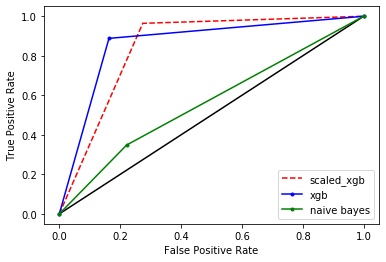

In [295]:
# calculate roc curves
xgb_scale_fpr, xgb_scale_tpr, _ = roc_curve(yuptest, models2_xgb_up[2].predict(Xuptest))
xgb_fpr, xgb_tpr, _ = roc_curve(yuptest, models_xgb_up[1].predict(Xuptest))
nb_fpr, nb_tpr, _ = roc_curve(yuptest, models_nb_up[0].predict(Xuptest))
# plot the roc curve for the model
plt.plot([0,0.5,1],[0,0.5,1], color = 'black')
plt.plot(xgb_scale_fpr, xgb_scale_tpr, linestyle='--', color = 'r',label='scaled_xgb')
plt.plot(xgb_fpr, xgb_tpr, marker='.', color = 'b', label='xgb')
plt.plot(nb_fpr, nb_tpr, marker='.', color = 'g', label='naive bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()